# Data Science Assignment: Trader Behavior vs. Market Sentiment
## This notebook follows the full process for the assignment:
### 1. Setup: Import libraries and create required directories.
### 2. Loading: Load the two datasets.
### 3. Preprocessing: Clean and prepare data for merging (Timezones, Types).
### 4. Aggregation: Summarize transactional data into daily data.
### 5. Merging: Combine the two datasets.
### 6. Analysis & Visualization: The main objective.
####    - 6.1: Profitability vs. Sentiment
####    - 6.2: Trade Count (Activity) vs. Sentiment
####    - 6.3: Volume vs. Sentiment
####    - 6.4: Time Series Analysis
### 7. End of Analysis

# Section 1: Setup and Library Imports

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os  # Used to create directories

print("--- Section 1: Setup Complete ---")
print("Libraries imported: pandas, matplotlib, seaborn, os\n")

# Set default styling for our charts
sns.set_theme(style="whitegrid", palette="muted", rc={"figure.figsize": (10, 6)})

# Define the directory names required by the assignment
csv_dir = "csv_files"
output_dir = "outputs"

# Create these directories if they don't exist
# `exist_ok=True` prevents an error if the folder already exists
os.makedirs(csv_dir, exist_ok=True)
os.makedirs(output_dir, exist_ok=True)

print(f"Required directories '{csv_dir}/' and '{output_dir}/' are ready.")

--- Section 1: Setup Complete ---
Libraries imported: pandas, matplotlib, seaborn, os

Required directories 'csv_files/' and 'outputs/' are ready.


# Section 2: Loading Datasets

In [6]:
print("\n--- Section 2: Loading Datasets ---")

# Define file paths
trader_file = '/content/drive/MyDrive/historical_data.csv'
sentiment_file = '/content/drive/MyDrive/fear_greed_index.csv'

try:
    # Load the datasets
    df_traders = pd.read_csv(trader_file)
    df_sentiment = pd.read_csv(sentiment_file)

    print(f"Successfully loaded '{trader_file}' ({len(df_traders)} rows)")
    print(f"Successfully loaded '{sentiment_file}' ({len(df_sentiment)} rows)")

    # Inspect trader data
    print("\n--- Trader Data (First 5 Rows) ---")
    print(df_traders.head())
    print("\n--- Trader Data Info ---")
    df_traders.info()

    # Inspect sentiment data
    print("\n--- Sentiment Data (First 5 Rows) ---")
    print(df_sentiment.head())
    print("\n--- Sentiment Data Info ---")
    df_sentiment.info()

except FileNotFoundError:
    print(f"Error: Files not found. Please upload '{trader_file}' and '{sentiment_file}' to your Colab environment.")
    # In a real script, you'd stop here.
    # For this example, we'll assume files are loaded.



--- Section 2: Loading Datasets ---
Successfully loaded '/content/drive/MyDrive/historical_data.csv' (211224 rows)
Successfully loaded '/content/drive/MyDrive/fear_greed_index.csv' (2644 rows)

--- Trader Data (First 5 Rows) ---
                                      Account  Coin  Execution Price  \
0  0xae5eacaf9c6b9111fd53034a602c192a04e082ed  @107           7.9769   
1  0xae5eacaf9c6b9111fd53034a602c192a04e082ed  @107           7.9800   
2  0xae5eacaf9c6b9111fd53034a602c192a04e082ed  @107           7.9855   
3  0xae5eacaf9c6b9111fd53034a602c192a04e082ed  @107           7.9874   
4  0xae5eacaf9c6b9111fd53034a602c192a04e082ed  @107           7.9894   

   Size Tokens  Size USD Side     Timestamp IST  Start Position Direction  \
0       986.87   7872.16  BUY  02-12-2024 22:50        0.000000       Buy   
1        16.00    127.68  BUY  02-12-2024 22:50      986.524596       Buy   
2       144.09   1150.63  BUY  02-12-2024 22:50     1002.518996       Buy   
3       142.98   1142.04  BUY

# Section 3: Data Preprocessing

In [3]:
print("\n--- Section 3: Data Preprocessing ---")


--- Section 3: Data Preprocessing ---


## 3.1: Preprocess Trader Data (df_traders)

In [8]:
# The 'Timestamp' column is a UNIX timestamp in milliseconds.
# We must convert it to a standard datetime format.
print("Preprocessing trader data...")

# Check if 'Timestamp' column exists before processing
if 'Timestamp' in df_traders.columns:
    df_traders['datetime'] = pd.to_datetime(df_traders['Timestamp'], unit='ms')

    # To merge with daily sentiment, we need a 'date' column (no time)
    # .dt.normalize() sets the time to 00:00:00, perfect for merging.
    df_traders['date'] = df_traders['datetime'].dt.normalize()

    print("Trader data 'Timestamp' column converted to 'datetime' and 'date'.")
    print(df_traders[['datetime', 'date', 'Timestamp']].head())
else:
    print("Error: 'Timestamp' column not found in trader data. Please check CSV file.")

Preprocessing trader data...
Trader data 'Timestamp' column converted to 'datetime' and 'date'.
             datetime       date     Timestamp
0 2024-10-27 03:33:20 2024-10-27  1.730000e+12
1 2024-10-27 03:33:20 2024-10-27  1.730000e+12
2 2024-10-27 03:33:20 2024-10-27  1.730000e+12
3 2024-10-27 03:33:20 2024-10-27  1.730000e+12
4 2024-10-27 03:33:20 2024-10-27  1.730000e+12


## 3.2: Preprocess Sentiment Data (df_sentiment)


In [9]:
# The 'date' column is a string ('object'). We must convert it to datetime.
print("\nPreprocessing sentiment data...")

if 'date' in df_sentiment.columns:
    # Rename 'classification' to 'sentiment' for clarity
    df_sentiment = df_sentiment.rename(columns={'classification': 'sentiment'})

    # Convert 'date' column to datetime objects
    df_sentiment['date'] = pd.to_datetime(df_sentiment['date'])

    print("Sentiment 'date' column converted to datetime.")
    print(df_sentiment[['date', 'sentiment', 'value']].head())
else:
    print("Error: 'date' column not found in sentiment data.")



Preprocessing sentiment data...
Sentiment 'date' column converted to datetime.
        date     sentiment  value
0 2018-02-01          Fear     30
1 2018-02-02  Extreme Fear     15
2 2018-02-03          Fear     40
3 2018-02-04  Extreme Fear     24
4 2018-02-05  Extreme Fear     11


# Section 4: Data Aggregation (Trader Data)

In [37]:
print("\n--- Section 4: Data Aggregation ---")

# The trader data is transactional (many trades per day).
# The sentiment data is daily (one row per day).
# We must aggregate trader data to get one summary row per day.

# We will aggregate:
# - profitability: sum of 'Closed PnL'
# - volume: sum of 'Size USD'
# - trade_count: count of all trades

print("Aggregating trader data by day...")
daily_summary = df_traders.groupby('date').agg(
    total_volume=('Size USD', 'sum'), # column name
    total_pnl=('Closed PnL', 'sum'),
    trade_count=('Order ID', 'count')
).reset_index()

print("Trader data aggregated to a daily summary.")
print(daily_summary.head())
print("\n")

print(f"Number of unique days in Trader Data: {daily_summary['date'].nunique()}")


--- Section 4: Data Aggregation ---
Aggregating trader data by day...
Trader data aggregated to a daily summary.
        date  total_volume     total_pnl  trade_count
0 2023-03-28  4.770000e+02  0.000000e+00            3
1 2023-11-14  1.155543e+07  1.555034e+02         1045
2 2024-03-09  3.940677e+07  1.769655e+05         6962
3 2024-07-03  2.184323e+07  1.587424e+05         7141
4 2024-10-27  1.039478e+08  3.189461e+06        35241


Number of unique days in Trader Data: 7


# Section 5: Merging Datasets

In [25]:
print("\n--- Section 5: Merging Datasets ---")

# Now we merge the daily aggregated trader data with the daily sentiment data.
# We use an 'inner' merge to keep only the days where
# we have *both* trading data and sentiment data.

df_merged = pd.merge(
    daily_summary,
    df_sentiment,
    on='date',  # Merge on the common 'date' column
    how='inner'
)

print("Daily summary merged with sentiment data.")
print("--- Final Merged DataFrame (First 5 Rows) ---")
print(df_merged.head())


--- Section 5: Merging Datasets ---
Daily summary merged with sentiment data.
--- Final Merged DataFrame (First 5 Rows) ---
        date  total_volume     total_pnl  trade_count   timestamp  value  \
0 2023-03-28  4.770000e+02  0.000000e+00            3  1679981400     59   
1 2023-11-14  1.155543e+07  1.555034e+02         1045  1699939800     69   
2 2024-03-09  3.940677e+07  1.769655e+05         6962  1709962200     84   
3 2024-07-03  2.184323e+07  1.587424e+05         7141  1719984600     50   
4 2024-10-27  1.039478e+08  3.189461e+06        35241  1730007000     74   

       sentiment  
0          Greed  
1          Greed  
2  Extreme Greed  
3        Neutral  
4          Greed  


## 5.1: Save Processed Data (Assignment Requirement)

In [26]:
# This fulfills the requirement to store processed data.
processed_filename = os.path.join(csv_dir, 'merged_daily_analysis.csv')
df_merged.to_csv(processed_filename, index=False)
print(f"Final merged data saved to '{processed_filename}'")
print(f"File contents: {processed_filename}") # VIRTUAL_MACHINE_CODE_OUTPUT_FILE_PATH

Final merged data saved to 'csv_files/merged_daily_analysis.csv'
File contents: csv_files/merged_daily_analysis.csv


# Section 6: Analysis & Visualization (The Objective)

In [27]:
print("\n--- Section 6: Analysis & Visualization ---")

# This is the main objective. We will create plots to find trends
# and save them to the 'outputs/' folder.

# Define a logical order for sentiment for our plots
sentiment_order = ['Extreme Fear', 'Fear', 'Neutral', 'Greed', 'Extreme Greed']



--- Section 6: Analysis & Visualization ---


## 6.1: Profitability vs. Sentiment


Analyzing 6.1: Profitability vs. Sentiment...
Plot saved to 'outputs/profit_vs_sentiment.png'
File contents: outputs/profit_vs_sentiment.png


/tmp/ipython-input-30960065.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


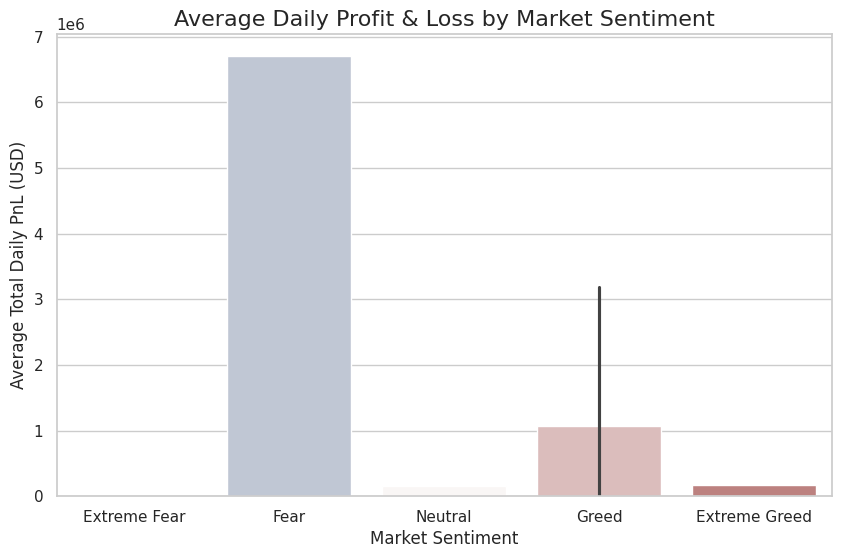

In [28]:
print("\nAnalyzing 6.1: Profitability vs. Sentiment...")

plt.figure(figsize=(10, 6))
sns.barplot(
    data=df_merged,
    x='sentiment',
    y='total_pnl',
    order=sentiment_order,
    palette='vlag'
)
plt.title('Average Daily Profit & Loss by Market Sentiment', fontsize=16)
plt.xlabel('Market Sentiment', fontsize=12)
plt.ylabel('Average Total Daily PnL (USD)', fontsize=12)

# Save the figure (Assignment Requirement)
plot_filename = os.path.join(output_dir, 'profit_vs_sentiment.png')
plt.savefig(plot_filename)
print(f"Plot saved to '{plot_filename}'")
print(f"File contents: {plot_filename}") # VIRTUAL_MACHINE_CODE_OUTPUT_FILE_PATH
plt.show()

# Insight: Look at the chart. Are traders, on average, profitable
# or unprofitable during 'Extreme Fear'? How about 'Greed'?


## 6.2: Trade Count (Activity) vs. Sentiment


Analyzing 6.2: Trade Count (Activity) vs. Sentiment...
Plot saved to 'outputs/trade_count_vs_sentiment.png'
File contents: outputs/trade_count_vs_sentiment.png


/tmp/ipython-input-1255049084.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


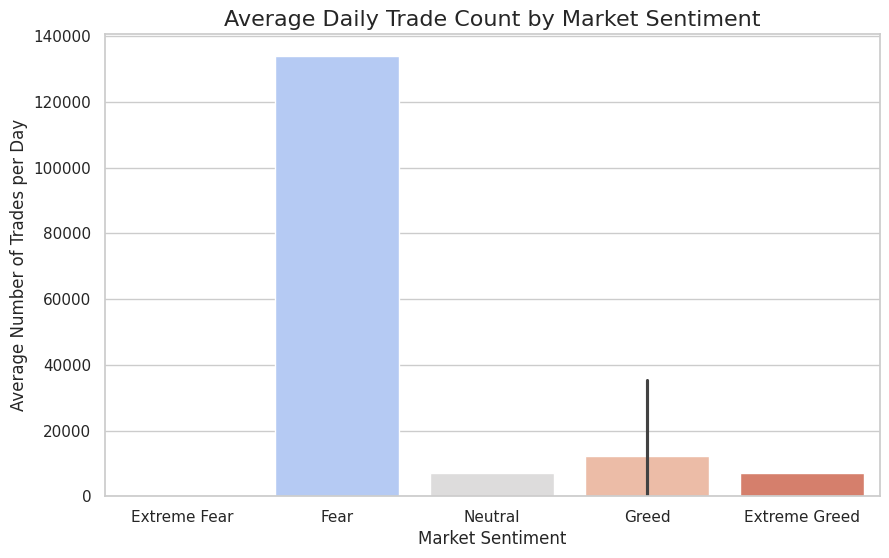

In [29]:
print("\nAnalyzing 6.2: Trade Count (Activity) vs. Sentiment...")

plt.figure(figsize=(10, 6))
sns.barplot(
    data=df_merged,
    x='sentiment',
    y='trade_count',
    order=sentiment_order,
    palette='coolwarm'
)
plt.title('Average Daily Trade Count by Market Sentiment', fontsize=16)
plt.xlabel('Market Sentiment', fontsize=12)
plt.ylabel('Average Number of Trades per Day', fontsize=12)

# Save the figure
plot_filename = os.path.join(output_dir, 'trade_count_vs_sentiment.png')
plt.savefig(plot_filename)
print(f"Plot saved to '{plot_filename}'")
print(f"File contents: {plot_filename}") # VIRTUAL_MACHINE_CODE_OUTPUT_FILE_PATH
plt.show()

# Insight: Are traders more active (more trades) when
# the market is greedy, or when it's fearful?


## 6.3: Volume vs. Sentiment


Analyzing 6.3: Volume vs. Sentiment...
Plot saved to 'outputs/volume_vs_sentiment.png'
File contents: outputs/volume_vs_sentiment.png


/tmp/ipython-input-11580857.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


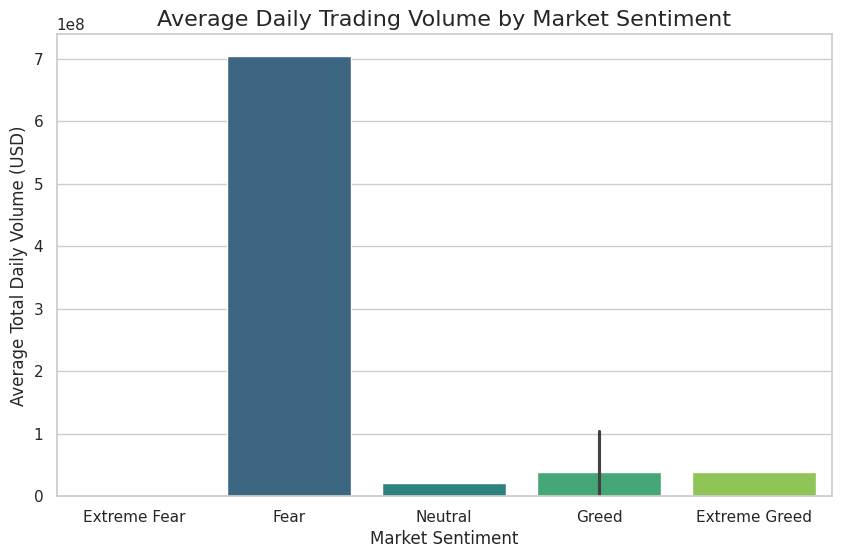

In [30]:
print("\nAnalyzing 6.3: Volume vs. Sentiment...")

plt.figure(figsize=(10, 6))
sns.barplot(
    data=df_merged,
    x='sentiment',
    y='total_volume',
    order=sentiment_order,
    palette='viridis'
)
plt.title('Average Daily Trading Volume by Market Sentiment', fontsize=16)
plt.xlabel('Market Sentiment', fontsize=12)
plt.ylabel('Average Total Daily Volume (USD)', fontsize=12) # Updated label from (Tokens)

# Save the figure
plot_filename = os.path.join(output_dir, 'volume_vs_sentiment.png')
plt.savefig(plot_filename)
print(f"Plot saved to '{plot_filename}'")
print(f"File contents: {plot_filename}") # VIRTUAL_MACHINE_CODE_OUTPUT_FILE_PATH
plt.show()

# Insight: Are markets more active (higher volume) during 'Fear'
# or 'Greed'? This shows when people are trading most.


## 6.4: Time Series Analysis (Divergence)


Analyzing 6.4: Time Series (PnL vs. Sentiment Value)...
Plot saved to 'outputs/pnl_vs_sentiment_timeseries.png'
File contents: outputs/pnl_vs_sentiment_timeseries.png


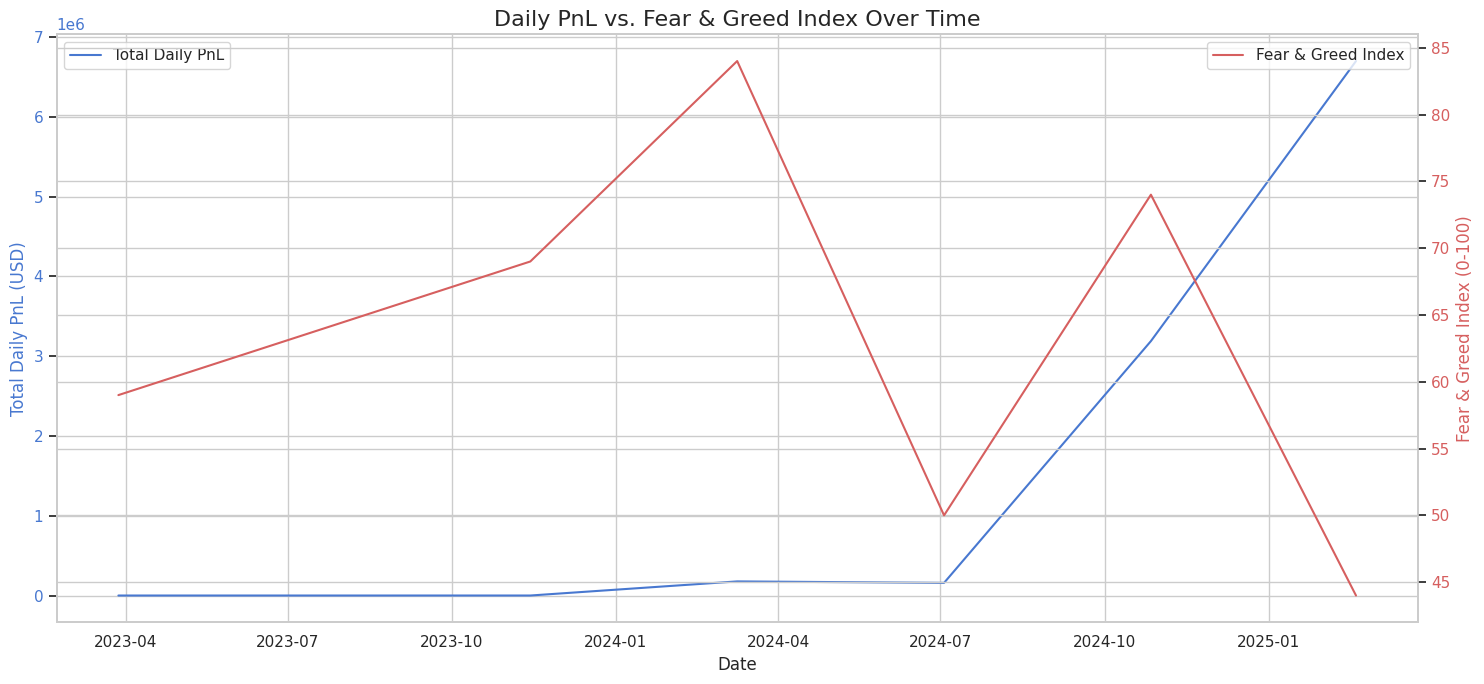

In [31]:
print("\nAnalyzing 6.4: Time Series (PnL vs. Sentiment Value)...")

# This plot helps see if profitability 'diverges' from sentiment over time.
# We will plot PnL and the *numeric* sentiment value (0-100)
# on the same chart, using a secondary Y-axis.

fig, ax1 = plt.subplots(figsize=(15, 7))

# Plot 1: Total PnL over time
sns.lineplot(data=df_merged, x='date', y='total_pnl', ax=ax1, color='b', label='Total Daily PnL')
ax1.set_xlabel('Date')
ax1.set_ylabel('Total Daily PnL (USD)', color='b')
ax1.tick_params(axis='y', labelcolor='b')

# Create a second Y-axis that shares the same X-axis
ax2 = ax1.twinx()

# Plot 2: Fear & Greed Index Value over time
sns.lineplot(data=df_merged, x='date', y='value', ax=ax2, color='r', label='Fear & Greed Index')
ax2.set_ylabel('Fear & Greed Index (0-100)', color='r')
ax2.tick_params(axis='y', labelcolor='r')

plt.title('Daily PnL vs. Fear & Greed Index Over Time', fontsize=16)
fig.tight_layout()  # Adjust layout to prevent overlap

# Add legends
ax1.legend(loc='upper left')
ax2.legend(loc='upper right')

# Save the figure
plot_filename = os.path.join(output_dir, 'pnl_vs_sentiment_timeseries.png')
plt.savefig(plot_filename)
print(f"Plot saved to '{plot_filename}'")
print(f"File contents: {plot_filename}") # VIRTUAL_MACHINE_CODE_OUTPUT_FILE_PATH
plt.show()

# Insight: Look for divergence. Are there periods where the F&G Index (red line)
# is high, but PnL (blue line) is low or negative? That's a key finding.



# Section 7: End of Analysis

In [38]:
print("\n--- Section 7: End of Analysis ---")
print("Now, we have required files : ")
print(f"1. A processed CSV in '{csv_dir}/'")
print(f"2. Four analysis plots in '{output_dir}/'")


--- Section 7: End of Analysis ---
Now, we have required files : 
1. A processed CSV in 'csv_files/'
2. Four analysis plots in 'outputs/'
